In [2]:
# Importando Librerias

import pandas as pd
import os, string, unicodedata, re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.util import ngrams
import nltk
from tensorflow.keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import random
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ReduceLROnPlateau



#

# **1. RECLASIFICANDO df_csv con df_clasificador**

## **1.1 Leyendo los archivos**

In [3]:
df_csv =  pd.read_csv('informacion_roles_actualizado.csv')

df_clasificador = pd.read_excel('CLASIFICADO_FINAL.xlsx')

- `df_csv`: Contiene los datos que tenemos que reclasificar con el dataframe df_clasificador
- `df_clasificador` corresponde al df donde se encuentran las etiquetas bien clasificadas

In [4]:
df_csv.head()

,rol,corte,fecha,folio,tramite,descripcion,fecha_ingreso
0,144280-2022,Valparaíso,05/02/2024,26.0,Actuación,COMUNICA CÚMPLASE CS,31/10/2022
1,144280-2022,Valparaíso,05/02/2024,25.0,Actuación,COMUNICA CÚMPLASE CS,31/10/2022
2,144280-2022,Valparaíso,05/02/2024,24.0,Resolución,Cúmplase CS,31/10/2022
3,144280-2022,Valparaíso,05/12/2023,23.0,Escrito,Recurso fallado Corte Suprema,31/10/2022
4,144280-2022,Valparaíso,15/06/2023,22.0,Resolución,(NMV)Concede Recurso (Intercon,31/10/2022


In [5]:
df_clasificador.head()

,Unnamed: 0,Descripcion,CLASIFICACION_FINAL
0,1461,Cumple lo ordenado / En Relaci,Téngase presente
1,202,Rec.Prot/D.cta.ONI.Sala Isapre,Dese cuenta
2,200,Cumple previo/Admisible GES,Admisibles
3,2621,Cambio código a masivo,ICA informa
4,1095,ocúrrase donde corresonda,ICA informa


## **1.2 Tratando los dfs**

In [6]:
df_clasificador['CLASIFICACION_FINAL'] = df_clasificador['CLASIFICACION_FINAL'].str.title()

In [7]:
df_clasificador['CLASIFICACION_FINAL'].value_counts()



CLASIFICACION_FINAL
Ica Solicita Diligencia    379
Agréguese A Tabla          319
Ica Informa                289
Evacua Informe             287
Admisibles                 255
Téngase Presente           203
Dese Cuenta                164
Apercibe                   160
Ica Amplia Plazo           138
Nhl                        119
Acoge                       69
Concede Apelación           54
Acuerdo                     43
Certifiquese                39
Cs                          38
Rechazada                   31
Art / Numeral               25
Archivado                   24
Fija Costas                 22
Inhabilidad                 22
Acumulación                 19
Oni                         17
Inadmisible/Omite           13
Prescinde                   13
Incompetencia               12
Multa                        7
Fallo/Desestima              5
Retira                       4
Inicio Tramitación           4
Name: count, dtype: int64

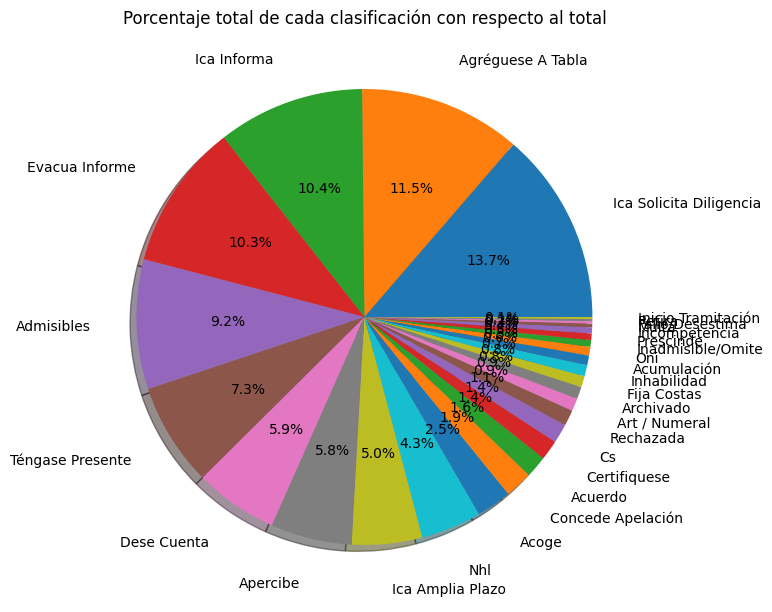

In [8]:
plt.figure(figsize=(10, 6))
plt.pie(df_clasificador['CLASIFICACION_FINAL'].value_counts(), labels=df_clasificador['CLASIFICACION_FINAL'].value_counts().index, autopct='%1.1f%%', labeldistance=1.2, normalize=True, shadow=True)
plt.tight_layout()
plt.title('Porcentaje total de cada clasificación con respecto al total')
plt.show()

- Tenemos bastante categorias que están muy poco presentes como es notorio en nuestro gráfico.
- Esto puede ser un problema considerando el desbalance de clases

### Generar el diccionario para CLASIFICACION FINAL - Descripción

In [9]:
dict_to_replace = df_clasificador.groupby('CLASIFICACION_FINAL')['Descripcion'].apply(list).to_dict()

- Cada descripción del dataframe se asocia a una respectiva categoria. Con esto podremos recategorizar el dataframe `df_csv`

In [10]:
# Función para reemplazar los datos
def mapear_valor(descripcion, diccionario):
    for key, values in diccionario.items():
        for value in values:
            if str(value).lower() in descripcion.lower():
                return key
    return descripcion  # Si no se encuentra en el diccionario, devuelve el valor original


In [11]:
# Generando una nueva columna en el df que no se encuentra clasificado correctamente reempalzando sus valores según el diccionario clasificador
df_csv['CLASIFICACION_CORRECTA']=df_csv.loc[(df_csv['tramite']=='Resolución') | (df_csv['tramite']=='Sentencia'), :]['descripcion'].apply(lambda x: mapear_valor(x, dict_to_replace))

In [12]:
df_csv = df_csv.loc[(df_csv['tramite']=='Resolución') | (df_csv['tramite']=='Sentencia'), :]

- Debido que en este problema solo nos interesa aquellos trámites que sean o Resolución o Sentencia, solo estos tipos de trámites son incluidos

In [13]:
# Obteniendo la lista de oraciones
sentences =  [ line for line in df_csv['descripcion'].values if line != 'Unknown']

In [14]:
sentences[:10]

['Cúmplase CS',
 '(NMV)Concede Recurso (Intercon',
 'NMV7/Acogida',
 'Agréguese Extraordinariamente',
 '7NMV/Estese al mérito',
 'nmv 3.Téngase Presente',
 '(8) Pide informe ONI',
 '(7)Estese al mérito de autos',
 '(5). Por Evacuado Informe, en',
 '(4)Interpuesto Recurso de Prot']

In [15]:
# Función para limpiar los textos
def cleaning_data(text):
    # Eliminar caracteres de puntuación
    clean_txt = "".join(char for char in text if char not in string.punctuation)
    
    # Normalizar el texto a ASCII
    text_normalized = unicodedata.normalize('NFKD', clean_txt).encode('ascii', 'ignore').decode('ascii')
    
    # Eliminar espacios adicionales y convertir a minúsculas
    text_cleaned = re.sub(r'\s{2,}', ' ', text_normalized).strip().lower()
    
    # Eliminar dígitos y palabras específicas (si no son útiles)
    text_cleaned = re.sub(r'^(\d+)\s|\d+(?=[a-zA-Z])', '', text_cleaned)  # Elimina números
    text_cleaned = re.sub(r'nmv', '', text_cleaned).strip()  # Elimina "nmv"
    
    return text_cleaned


In [16]:
# Oraciones limpias
clean_data = [cleaning_data(t) for t in sentences]

In [17]:
clean_data[:10]

['cumplase cs',
 'concede recurso intercon',
 'acogida',
 'agreguese extraordinariamente',
 'estese al merito',
 'tengase presente',
 'pide informe oni',
 'estese al merito de autos',
 'por evacuado informe en',
 'interpuesto recurso de prot']

## Eliminando las stopwords

In [18]:
import nltk
from nltk.corpus import stopwords

# Descargar las stopwords si no lo has hecho antes
nltk.download('stopwords')

# Obtener las stopwords en español
stop_words_es = set(stopwords.words('spanish'))

print(stop_words_es)

{'tenían', 'tengamos', 'sea', 'tengan', 'estuvieras', 'tenemos', 'tuvieran', 'todos', 'serías', 'tuviese', 'fui', 'vosotras', 'hubieran', 'mis', 'tendríais', 'algunas', 'estado', 'nos', 'son', 'nuestro', 'tengas', 'estuviste', 'habidas', 'estuvieses', 'más', 'habrían', 'estar', 'cual', 'hasta', 'sentida', 'estuvimos', 'tenías', 'habrás', 'seríamos', 'sobre', 'nosotros', 'eras', 'tenía', 'de', 'habíais', 'ella', 'mi', 'hay', 'hubo', 'tengo', 'tenga', 'e', 'del', 'estén', 'teniendo', 'hubieras', 'tuvieseis', 'fue', 'yo', 'tuvierais', 'somos', 'han', 'había', 'hubieron', 'seas', 'antes', 'tendréis', 'tenida', 'tuve', 'tuviera', 'estarían', 'hubiera', 'esos', 'tendrá', 'qué', 'fuesen', 'tenido', 'tienes', 'ti', 'desde', 'los', 'tuvimos', 'mías', 'hubisteis', 'tengáis', 'estaríais', 'tiene', 'fueran', 'su', 'mucho', 'contra', 'tendrías', 'este', 'estuvo', 'está', 'con', 'algunos', 'donde', 'quienes', 'tu', 'estamos', 'se', 'ellas', 'os', 'estuvisteis', 'mía', 'hubiésemos', 'habríamos', 'mío

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kev_g\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
clean_data = [word for word in clean_data if word not in stop_words_es]

## TOKENIZACIÓN

In [20]:

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words= 2300, oov_token="<OOV>")

In [21]:
tokenizer.fit_on_texts(clean_data)

# Al vocabulario total que tenemos le sumamos 1 para asegurarnos que incluya el indice 0 del pading (tokenizer.word_index = dict)
total_words = len(tokenizer.word_index) + 1 

sequences = tokenizer.texts_to_sequences(clean_data)

max_sequence_len = max([len(x) for x in sequences])



In [22]:
df_csv['CLASIFICACION_CORRECTA'].value_counts()

CLASIFICACION_CORRECTA
Admisibles                 7608
Evacua Informe             6888
Inicio Tramitación         6360
Agréguese A Tabla          6099
Concede Apelación          4636
Cs                         4485
Rechazada                  3560
Acoge                      2349
Ica Amplia Plazo           1793
Ica Informa                1593
Dese Cuenta                1400
Ica Solicita Diligencia    1015
Téngase Presente            588
Inadmisible/Omite           453
Nhl                         371
Apercibe                    319
Incompetencia               269
Archivado                   191
Oni                         173
Inhabilidad                 125
Certifiquese                113
Art / Numeral               111
Acuerdo                      96
Acumulación                  67
Fija Costas                  64
Prescinde                    51
Fallo/Desestima              14
Multa                         9
Retira                        8
Name: count, dtype: int64

In [23]:
from sklearn.preprocessing import LabelEncoder

# 1. Convertir etiquetas de texto a números
label_encoder = LabelEncoder()
df_csv['CLASIFICACION_NUM'] = label_encoder.fit_transform(df_csv['CLASIFICACION_CORRECTA'])


# 2. Convertir etiquetas numéricas a one-hot encoding
y_categorical = to_categorical(df_csv['CLASIFICACION_NUM'])

In [24]:
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.3, random_state=42)



## **2. MODELACIÓN**

In [25]:

# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=total_words, output_dim=50, input_length=max_sequence_len))

# Capa LSTM
model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

# Capa densa
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Resumen del modelo
model.summary()





c:\Users\kev_g\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:


# Compilación del modelo
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Entrenamiento con class_weights
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=5, batch_size=32, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/5
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 91s 79ms/step - accuracy: 0.6573 - loss: 1.2369 - val_accuracy: 0.9700 - val_loss: 0.1643 - learning_rate: 0.0010
Epoch 2/5
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 86s 77ms/step - accuracy: 0.9546 - loss: 0.2174 - val_accuracy: 0.9748 - val_loss: 0.1428 - learning_rate: 0.0010
Epoch 3/5
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 85s 76ms/step - accuracy: 0.9678 - loss: 0.1592 - val_accuracy: 0.9854 - val_loss: 0.1027 - learning_rate: 0.0010
Epoch 4/5
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 81s 73ms/step - accuracy: 0.9820 - loss: 0.1060 - val_accuracy: 0.9877 - val_loss: 0.0916 - learning_rate: 0.0010
Epoch 5/5
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 88s 79ms/step - accuracy: 0.9865 - loss: 0.0869 - val_accuracy: 0.9892 - val_loss: 0.0850 - learning_rate: 0.0010


In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def metricas_clases(X_test, model):

    """
    Función que genera probabilidades para el conjunto de prueba y las combierte a las clases predichas. También genera informe de clasificación y matriz de confusion.
    return: Retorna un dataframe con el clasification report.
    """
    # Predecir las probabilidades para el conjunto de prueba
    y_pred_probs = model.predict(X_test)

    # Convertir las probabilidades a clases predichas
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Obtener las etiquetas reales
    y_true = np.argmax(y_test, axis=1)

    # Generar el informe de clasificación
    print("Informe de clasificación:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    
    classification_report_dict = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

    df_cr = pd.DataFrame(classification_report_dict).transpose()

    # Generar la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.title('Matriz de Confusión')
    plt.show()

    return df_cr

477/477 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       1.00      1.00      1.00       733
                Acuerdo       0.88      0.97      0.92        29
            Acumulación       0.79      0.95      0.86        20
             Admisibles       1.00      1.00      1.00      2297
      Agréguese A Tabla       1.00      1.00      1.00      1810
               Apercibe       0.89      0.92      0.91        92
              Archivado       0.89      0.87      0.88        47
          Art / Numeral       0.76      1.00      0.86        31
           Certifiquese       0.87      0.32      0.46        41
      Concede Apelación       1.00      1.00      1.00      1394
                     Cs       1.00      1.00      1.00      1295
            Dese Cuenta       0.98      0.98      0.98       447
         Evacua Informe       0.99      0.99      0.99      2045
        Fallo/Desest

c:\Users\kev_g\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kev_g\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kev_g\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

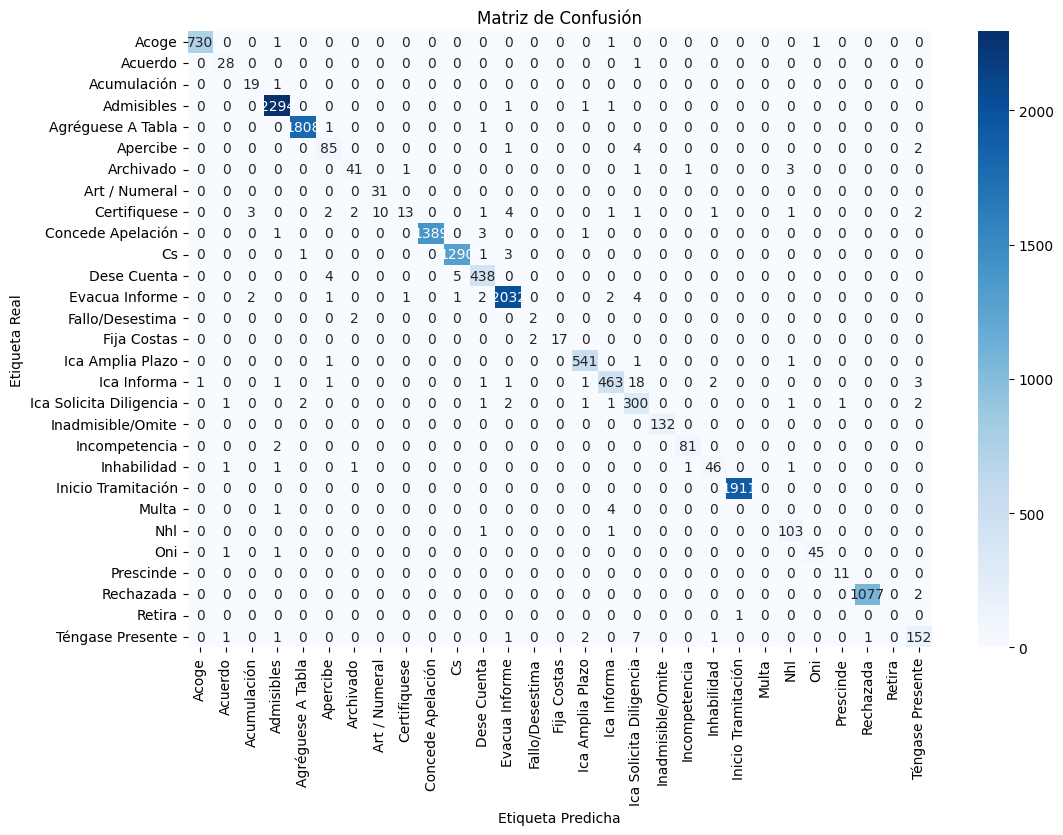

In [28]:
df_clasificacion_sin_tratar = metricas_clases(X_test, model)

- El modelo en general se desempeña bastante bien con excepcion de las clases que tienen bajo soporte como:
    - Fallo/Desestima
    - Multa
    - Retira

- Hay clases que tienen metricas excepcionalmente buena como admisible, agreguese a tabla

## **2.1 DESBALANCEO DE CLASES**

In [29]:

# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=total_words, output_dim=50, input_length=max_sequence_len))

# Capa LSTM
model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

# Capa densa
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)





c:\Users\kev_g\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


- Al mismo modelo anterior vamos a realizar un class_weights para ver si podemos mejorar las clases que tienen mal desempeño

## ** 2.4. Balanceando las clases con class_weights**

In [30]:
y_train_int = y_train.argmax(axis=1)  # De one-hot a entero


In [31]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)
class_weights_dict = dict(enumerate(class_weights))

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=5, batch_size=32, 
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/5
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 81s 71ms/step - accuracy: 0.4882 - loss: 2.7497 - val_accuracy: 0.9629 - val_loss: 0.2397 - learning_rate: 0.0010
Epoch 2/5
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 82s 74ms/step - accuracy: 0.9104 - loss: 0.9726 - val_accuracy: 0.9544 - val_loss: 0.2335 - learning_rate: 0.0010
Epoch 3/5
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 74s 66ms/step - accuracy: 0.9280 - loss: 0.6926 - val_accuracy: 0.9637 - val_loss: 0.1933 - learning_rate: 0.0010
Epoch 4/5
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 77s 70ms/step - accuracy: 0.9488 - loss: 0.4847 - val_accuracy: 0.9765 - val_loss: 0.1694 - learning_rate: 0.0010
Epoch 5/5
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 76s 68ms/step - accuracy: 0.9528 - loss: 0.3864 - val_accuracy: 0.9837 - val_loss: 0.1424 - learning_rate: 0.0010


477/477 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       1.00      0.99      1.00       733
                Acuerdo       0.91      1.00      0.95        29
            Acumulación       0.63      0.95      0.76        20
             Admisibles       1.00      1.00      1.00      2297
      Agréguese A Tabla       1.00      1.00      1.00      1810
               Apercibe       0.72      0.93      0.82        92
              Archivado       0.98      0.89      0.93        47
          Art / Numeral       0.86      1.00      0.93        31
           Certifiquese       0.81      0.73      0.77        41
      Concede Apelación       1.00      1.00      1.00      1394
                     Cs       1.00      1.00      1.00      1295
            Dese Cuenta       0.99      0.96      0.97       447
         Evacua Informe       1.00      0.97      0.98      2045
        Fallo/Desest

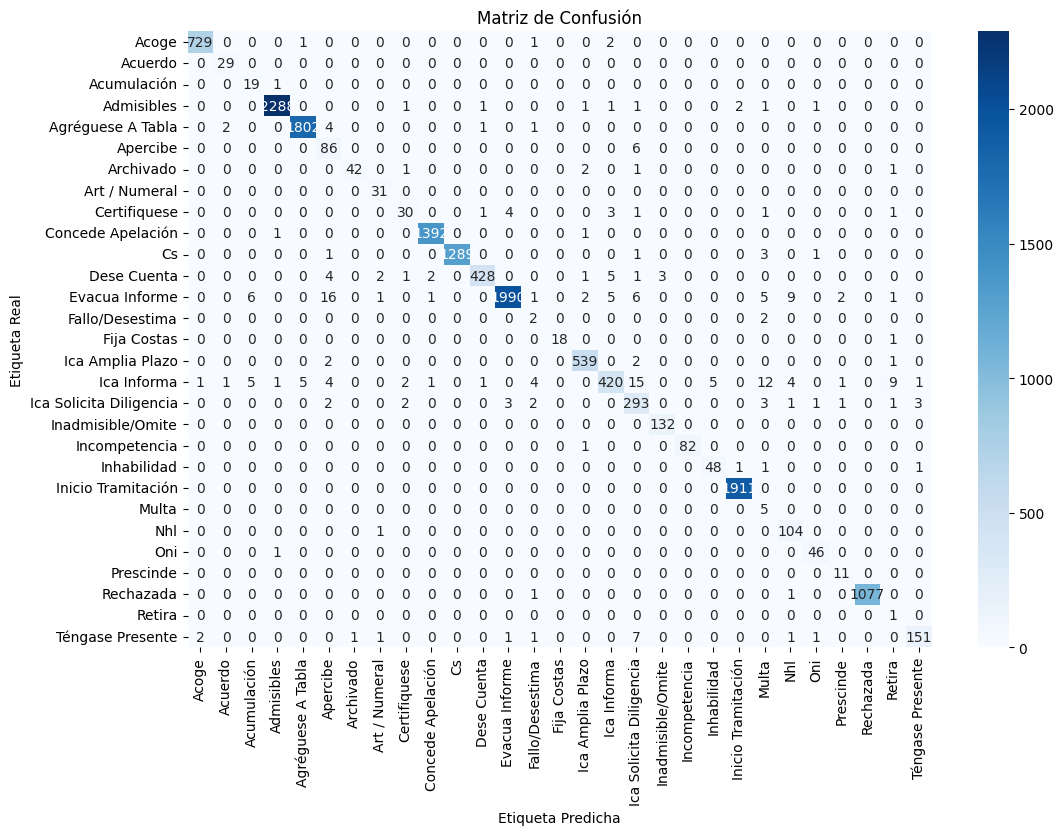

In [32]:
df_classweights = metricas_clases(X_test, model)

## **2.3 Resumen hasta ahora**

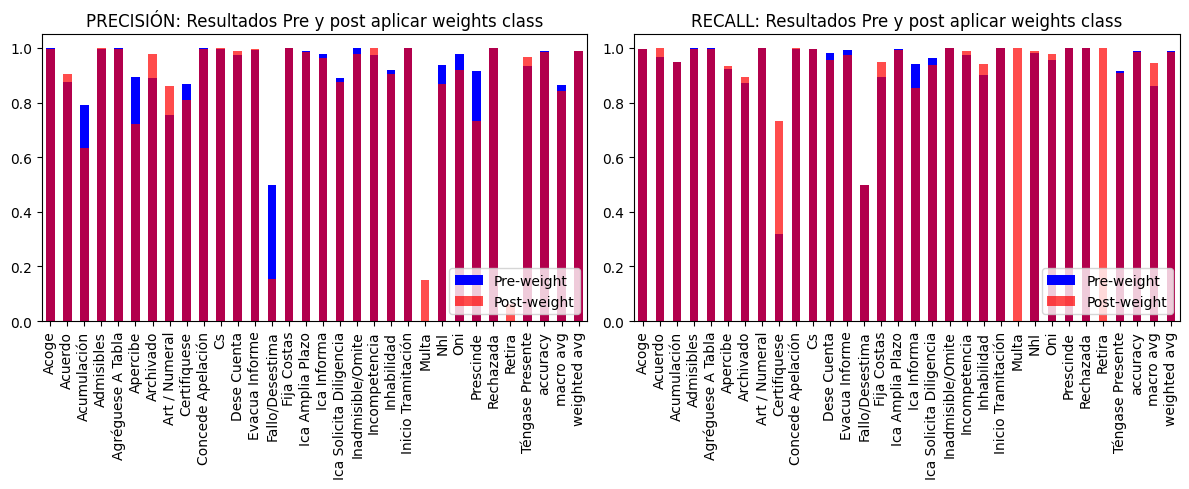

In [33]:
df_resumen = pd.concat([df_clasificacion_sin_tratar, df_classweights], axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Precision
df_clasificacion_sin_tratar.iloc[:, 0].plot(kind='bar', label='Pre-weight', color='blue', ax=ax[0])
df_classweights.iloc[:, 0].plot(kind='bar', alpha=0.7, color='red', label='Post-weight', ax = ax[0])

ax[0].legend(loc='lower right')
ax[0].set_title('PRECISIÓN: Resultados Pre y post aplicar weights class')

# Recall
df_clasificacion_sin_tratar.iloc[:, 1].plot(kind='bar', label='Pre-weight', color='blue', ax=ax[1])
df_classweights.iloc[:, 1].plot(kind='bar', alpha=0.7, color='red', label='Post-weight', ax = ax[1])

ax[1].legend(loc='lower right')
ax[1].set_title('RECALL: Resultados Pre y post aplicar weights class')

plt.tight_layout()
plt.show()


### **Clases resultante con menor precision**
`Acuerdo`, `Acumulación`, `Apercibe`, `Archivado`, `Art / Numeral`, `ICA Solicita Diligencia`, `Inhabilidad`, `ONI`, `Precinde` y por último el macro avg

### **Clases mejoradas**

`Fallo/Desestima`, `Inadmisible/Omite`, `Multa`, `NHL`, `Téngase presente`

Logramos el cometido de poder sacar de 0 precision las clases con el class weights pero debido lo más probable al bajo soporte y ejemplos disponibles tenemos muy bajas **precisiones < 50 %**


### **MÉTRICA MÁS IMPORTANTE**

En nuestro caso la **precision** es lo más importante porque buscamos tratar de equivocarnos lo menos posible al clasificar los textos. Por esta razon o necesitamos unir alguna categoria con otra para disminuir la cantidad de clases y asi aumentar los ejemplos de las clases minoritarias o aplicar SMOTE con el riesgo de introducir ruido dentro de nuestros datos

### **CONCLUSIÓN**

#### Las clases con problemas son las siguientes:
- Acuerdo, Acumulación, Apercibe, Archivado, Certifiquese,  Fallo/Desestima, Fija Costas, Ica Solicita Diligencia, Inhabilidad, Multa, Nhl, Retira
Prescinde

Por lo tanto intetaremos aplicar **SMOTE** 


## APLICANDO SMOTE EN VEZ DE CLASS_WEIGHTS

In [34]:

padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')


X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42)
# 2. Convertir etiquetas de una codificación categórica (one-hot) a valores enteros
y_train_int = y_train.argmax(axis=1)  # De one-hot a entero

# 3. Aplicar SMOTE para generar datos sintéticos
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_int)

# 4. Volver a convertir las etiquetas generadas por SMOTE a one-hot encoding
y_train_resampled = to_categorical(y_train_resampled, num_classes=y_categorical.shape[1])

# Verificar los tamaños después de SMOTE
print(f"Tamaño original: {X_train.shape}, Tamaño después de SMOTE: {X_train_resampled.shape}")

Tamaño original: (40646, 163), Tamaño después de SMOTE: (175450, 163)


In [35]:

# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=total_words, output_dim=50, input_length=max_sequence_len))

# Capa LSTM
model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

# Capa densa
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)




c:\Users\kev_g\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [36]:

# Resumen del modelo
model.summary()
history = model.fit(X_train_resampled, y_train_resampled, 
                    validation_data=(X_test, y_test), 
                    epochs=5, batch_size=32, 
                    callbacks=[early_stopping, reduce_lr])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 334s 60ms/step - accuracy: 0.7048 - loss: 1.1119 - val_accuracy: 0.9814 - val_loss: 0.1274 - learning_rate: 0.0010
Epoch 2/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 362s 66ms/step - accuracy: 0.9116 - loss: 0.3774 - val_accuracy: 0.9847 - val_loss: 0.1215 - learning_rate: 0.0010
Epoch 3/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 356s 65ms/step - accuracy: 0.9265 - loss: 0.3145 - val_accuracy: 0.9842 - val_loss: 0.1122 - learning_rate: 0.0010
Epoch 4/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 330s 60ms/step - accuracy: 0.9372 - loss: 0.2692 - val_accuracy: 0.9854 - val_loss: 0.1003 - learning_rate: 0.0010
Epoch 5/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 341s 62ms/step - accuracy: 0.9428 - loss: 0.2460 - val_accuracy: 0.9832 - val_loss: 0.1160 - learning_rate: 0.0010


318/318 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       1.00      0.99      0.99       479
                Acuerdo       0.84      0.94      0.89        17
            Acumulación       0.35      1.00      0.52         7
             Admisibles       1.00      0.99      1.00      1558
      Agréguese A Tabla       1.00      0.99      1.00      1223
               Apercibe       0.87      0.96      0.91        54
              Archivado       0.93      0.90      0.92        31
          Art / Numeral       1.00      0.94      0.97        17
           Certifiquese       0.45      0.61      0.52        28
      Concede Apelación       1.00      1.00      1.00       937
                     Cs       1.00      0.99      1.00       874
            Dese Cuenta       0.98      0.97      0.97       286
         Evacua Informe       0.99      0.99      0.99      1343
        Fallo/Desesti

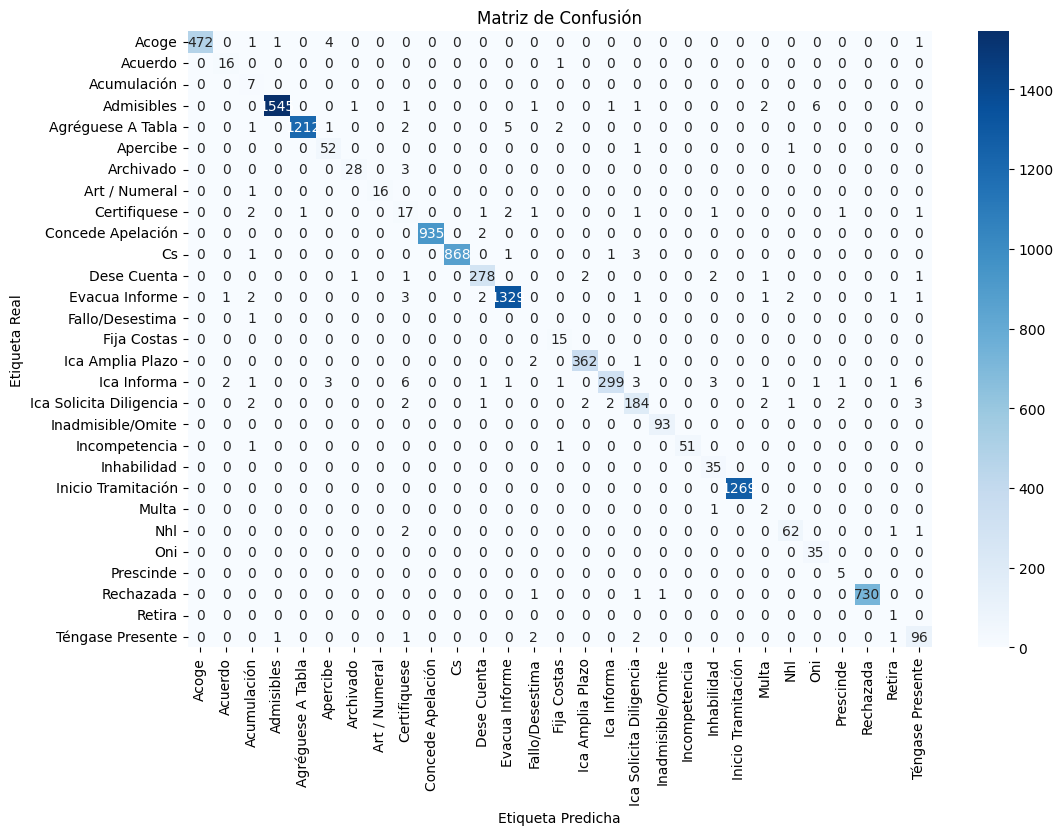

In [37]:
df_smote = metricas_clases(X_test, model)

In [38]:
df_resumen = pd.concat([
    df_clasificacion_sin_tratar.add_suffix('_SIN_TRATAR'),
    df_classweights.add_suffix('_CLASS_WEIGHT'),
    df_smote.add_suffix('_SMOTE')
], axis=1)

In [39]:
df_resumen

,precision_SIN_TRATAR,recall_SIN_TRATAR,f1-score_SIN_TRATAR,support_SIN_TRATAR,precision_CLASS_WEIGHT,recall_CLASS_WEIGHT,f1-score_CLASS_WEIGHT,support_CLASS_WEIGHT,precision_SMOTE,recall_SMOTE,f1-score_SMOTE,support_SMOTE
Acoge,0.998632,0.995907,0.997268,733.000000,0.995902,0.994543,0.995222,733.00000,1.000000,0.985386,0.992639,479.000000
Acuerdo,0.875000,0.965517,0.918033,29.000000,0.906250,1.000000,0.950820,29.00000,0.842105,0.941176,0.888889,17.000000
Acumulación,0.791667,0.950000,0.863636,20.000000,0.633333,0.950000,0.760000,20.00000,0.350000,1.000000,0.518519,7.000000
Admisibles,0.995660,0.998694,0.997175,2297.000000,0.998255,0.996082,0.997167,2297.00000,0.998707,0.991656,0.995169,1558.000000
Agréguese A Tabla,0.998343,0.998895,0.998619,1810.000000,0.996681,0.995580,0.996130,1810.00000,0.999176,0.991006,0.995074,1223.000000
Apercibe,0.894737,0.923913,0.909091,92.000000,0.722689,0.934783,0.815166,92.00000,0.866667,0.962963,0.912281,54.000000
Archivado,0.891304,0.872340,0.881720,47.000000,0.976744,0.893617,0.933333,47.00000,0.933333,0.903226,0.918033,31.000000
Art / Numeral,0.756098,1.000000,0.861111,31.000000,0.861111,1.000000,0.925373,31.00000,1.000000,0.941176,0.969697,17.000000
Certifiquese,0.866667,0.317073,0.464286,41.000000,0.810811,0.731707,0.769231,41.00000,0.447368,0.607143,0.515152,28.000000
Concede Apelación,1.000000,0.996413,0.998203,1394.000000,0.997135,0.998565,0.997849,1394.00000,1.000000,0.997866,0.998932,937.000000


In [40]:
df_resumen[['precision_SIN_TRATAR', 'precision_CLASS_WEIGHT', 'precision_SMOTE', 'support_SIN_TRATAR', 'support_CLASS_WEIGHT', 'support_SMOTE' ]]

,precision_SIN_TRATAR,precision_CLASS_WEIGHT,precision_SMOTE,support_SIN_TRATAR,support_CLASS_WEIGHT,support_SMOTE
Acoge,0.998632,0.995902,1.000000,733.000000,733.00000,479.000000
Acuerdo,0.875000,0.906250,0.842105,29.000000,29.00000,17.000000
Acumulación,0.791667,0.633333,0.350000,20.000000,20.00000,7.000000
Admisibles,0.995660,0.998255,0.998707,2297.000000,2297.00000,1558.000000
Agréguese A Tabla,0.998343,0.996681,0.999176,1810.000000,1810.00000,1223.000000
Apercibe,0.894737,0.722689,0.866667,92.000000,92.00000,54.000000
Archivado,0.891304,0.976744,0.933333,47.000000,47.00000,31.000000
Art / Numeral,0.756098,0.861111,1.000000,31.000000,31.00000,17.000000
Certifiquese,0.866667,0.810811,0.447368,41.000000,41.00000,28.000000
Concede Apelación,1.000000,0.997135,1.000000,1394.000000,1394.00000,937.000000


In [41]:
umbral_soporte = df_resumen['support_SMOTE'].median()  # Se puede ajustar según la distribución

# Filtrar las clases con bajo soporte en SMOTE
clases_bajo_soporte = df_resumen[df_resumen['support_SMOTE'] < umbral_soporte]
clases_bajo_soporte

,precision_SIN_TRATAR,recall_SIN_TRATAR,f1-score_SIN_TRATAR,support_SIN_TRATAR,precision_CLASS_WEIGHT,recall_CLASS_WEIGHT,f1-score_CLASS_WEIGHT,support_CLASS_WEIGHT,precision_SMOTE,recall_SMOTE,f1-score_SMOTE,support_SMOTE
Acuerdo,0.875000,0.965517,0.918033,29.000000,0.906250,1.000000,0.950820,29.00000,0.842105,0.941176,0.888889,17.000000
Acumulación,0.791667,0.950000,0.863636,20.000000,0.633333,0.950000,0.760000,20.00000,0.350000,1.000000,0.518519,7.000000
Apercibe,0.894737,0.923913,0.909091,92.000000,0.722689,0.934783,0.815166,92.00000,0.866667,0.962963,0.912281,54.000000
Archivado,0.891304,0.872340,0.881720,47.000000,0.976744,0.893617,0.933333,47.00000,0.933333,0.903226,0.918033,31.000000
Art / Numeral,0.756098,1.000000,0.861111,31.000000,0.861111,1.000000,0.925373,31.00000,1.000000,0.941176,0.969697,17.000000
Certifiquese,0.866667,0.317073,0.464286,41.000000,0.810811,0.731707,0.769231,41.00000,0.447368,0.607143,0.515152,28.000000
Fallo/Desestima,0.500000,0.500000,0.500000,4.000000,0.153846,0.500000,0.235294,4.00000,0.000000,0.000000,0.000000,1.000000
Fija Costas,1.000000,0.894737,0.944444,19.000000,1.000000,0.947368,0.972973,19.00000,0.750000,1.000000,0.857143,15.000000
Incompetencia,0.975904,0.975904,0.975904,83.000000,1.000000,0.987952,0.993939,83.00000,1.000000,0.962264,0.980769,53.000000
Inhabilidad,0.920000,0.901961,0.910891,51.000000,0.905660,0.941176,0.923077,51.00000,0.833333,1.000000,0.909091,35.000000


### **CONCLUSION**

Según lo observado con la aplicación del SMOTE no se observa una mejora considerable en las metricas que nos interesa de las clases que tienen menor soporte. Aplicar ya sea un undersampling o un data augmentation podria ser una buena opción. Considerando que ya se aplicó un tratamiento a los datos en si, vamos a tratar de realizar un aumento de datos

## **3. DATA AUGMENTATION**

In [89]:
# Eliminando certifiquese agregandola a la clasificación ICA informa
df_csv.loc[df_csv['CLASIFICACION_CORRECTA'].isin(['Certifiquese', 'Pone en conc.inhabilidad']), 'CLASIFICACION_CORRECTA'] = 'Ica Informa'

In [90]:
cortes_de_chile = [
    "Arica",
    "Iquique",
    "Antofagasta",
    "Copiapó",
    "La Serena",
    "Valparaíso",
    "Santiago",
    "Rancagua",
    "Talca",
    "Chillán",
    "Concepción",
    "Temuco",
    "Valdivia",
    "Puerto Montt",
    "Coyhaique",
    "Punta Arenas"
]

abreviaciones_cortes = [
    "ARC",  # Arica
    "IQQ",  # Iquique
    "ANT",  # Antofagasta
    "COP",  # Copiapó
    "SER",  # La Serena
    "VALP",  # Valparaíso (también se usa "VALPO")
    "STGO",  # Santiago
    "RCGA",  # Rancagua (también se usa "RANC")
    "TAL",  # Talca
    "CHILL",  # Chillán
    "CCP",  # Concepción
    "TEM",  # Temuco
    "VALD",  # Valdivia
    "PMO",  # Puerto Montt (también se usa "PTOM")
    "COY",  # Coyhaique
    "PA"  # Punta Arenas
]


formas_corte_apelaciones = [
    "C.A.",
    "CA",
    "Corte Apel.",
    "Ilma. C.A.",
    "Ilustrísima Corte de Apelaciones",
    "Excelentísima Corte de Apelaciones",
    "Corte de Apelaciones de",
    "Corte de",
    "Apelaciones de",
    "Tribunal de Apelaciones"
]

variaciones_recurrente_recurrida = [
    "Recurrida",
    "Recurrente",
    "Rte.",  
    "Rcta.",  
    "Rcte.",  
    "Rcrte.", 
    "Rcrda.",  
    "Recurrda",  
    "Recurr.",  
    "Rdo.",  
    "Rda.", 
    "Recur.",  
    "Demandante recurrente",
    "Demandado recurrente",
    "Apelante",
    "Impugnante"
]

random.seed(42)


In [91]:

variaciones_acuerdo = [
    f"Estése a la disponibilidad de esta corte de apelaciones de { random.choice(abreviaciones_cortes)} a su ingreso y prioridad.",
    f"Estése a la disponibilidad de esta corte de apelaciones de {random.choice(cortes_de_chile)} a su ingreso y prioridad.",
    "Pase a los ministros del acuerdo.",
    f"Rija el estado de acuerdo {random.choice(abreviaciones_cortes)}.",
    "Acuerdo.",
    "Nota de acuerdo: redacción Erika Villegas.",
    "Certifica alegato y acuerdo.",
    "Cert. de acuerdo.",
    "Nota de acuerdo: redacción ministra Valentina Salvo.",
    "Nota de acuerdo: redacción Jimena Troncoso.",
    "Nota de acuerdo: redacción Jimena Troncoso.", 
    "Acogida (fallo del acuerdo).",
    "Incorpórese a la tabla respectiva de acuerdo a su disponibilidad.",
    "Nota de acuerdo: redacción Sra. Valentina Salvo.",
    "Certificado causa en acuerdo.",
    "Nota de acuerdo: redacción Rafael Andrade Díaz.",
    "Nota de acuerdo: redacción Gonzalo Roja.",
    "Nota de acuerdo, redacción Sr. Gonzalo Montroy.",
    "Suspensión vista de común acuerdo art. 165 N° 5 C.P.C.",
    "Nota de acuerdo: redacción Claudia Vilches.",
    "Pase a los ministros del acuerdo a la sala.",
    "Nota de acuerdo redacción: Hadolff Ascencio.",
    "Nota de acuerdo: designa redacción Gonzalo Rojas.",
    "Nota de acuerdo: redacción Valentina Calvo.",
    "Nota de acuerdo: redacción Rafael Andrade.",
    "Nota de acuerdo: redacción Camilo Álvarez.",
    "Pase a los min del acuerdo.",
    "En acuerdo (R. Cerda, V. Iza y MF. Durán).",
    "En acuerdo (R. Cerda, MF. Durán y M. Escobar).",
    "Nota acuerdo.",
    "Nota de acuerdo redacción Mauricio Silva.",
    "Nota de acuerdo: Sr. Gonzalo Montroy.",
    "Nota de acuerdo: redacción Gonzalo Montroy.",
    "Pase a ministros del acuerdo.",
    "Nota de acuerdo.",
    "Certif. alegato y acuerdo.",
    "Certificado de acuerdo.",
    "Certificado alegato y acuerdo.",
    "En acuerdo.",
    "Cert. acuerdo.",
    "Nota acuerdo.",
    "Certificado tránsito del estudio al acuerdo.",
    "Certificación acuerdo.",
    "Certificación causa en acuerdo.",
    "Acuerdo.",
    "Pase a ministros acuerdo.",
    "Nota de acuerdo, redacción Maximiliano Escobar.",
    "Al folio 52: por cumplido lo ordenado, rija el estado de acuerdo.",
    "Certif. acuerdo."
]

def generar_frase_acuerdo():
    """
    Selecciona de forma aleatoria una de las variaciones definidas para la clase "Acuerdo".
    """
    return random.choice(variaciones_acuerdo)

# Generar varias frases para la clase "Acuerdo"
frases_acuerdo = [generar_frase_acuerdo() for _ in range(200)]

In [92]:
import random
# Lista de variaciones para la clase "Apercibe"
apercibe_variations = [
    f"Para apercibe hace efectivo apercibimiento a {random.choice(variaciones_recurrente_recurrida)}.",
    "Previo a proveer, hágase coincidir la suma con el cuerpo del escrito, dentro del plazo establecido, bajo apercibimiento de resolver conforme al mérito de autos.",
    "Atendido el tiempo transcurrido, se hace efectivo el apercibimiento decretado.",
    "Se notifica apercibimiento a la parte recurrente.",
    "Se impone apercibimiento conforme a lo resuelto en autos.",
    f"No habiendo informado, se procede al apercibimiento {random.choice(variaciones_recurrente_recurrida)} .",
    "Apercibimiento: se deja sin efecto la resolución y se ordena archivar los antecedentes.",
    "Se ordena apercibimiento a la parte para que cumpla en plazo.",
    "Ante la inactividad, se declara apercibimiento y se procede a archivar la causa.",
    "Se realiza apercibimiento y se advierte multa en caso de incumplimiento.",
    f"Apercibimiento efectivo a la parte {random.choice(variaciones_recurrente_recurrida)}, comuníquese y archívese.",
    "Se notifica apercibimiento a la parte para cumplir con lo ordenado.",
    "Se procede al apercibimiento, solicitando informe dentro del plazo establecido.",
    "Apercibimiento decretado, a falta de respuesta.",
    "Bajo apercibimiento, se requiere respuesta en cinco días hábiles.",
    "El apercibimiento se efectúa debido a la inacción de la parte recurrida.",
    "Apercibimiento: se deja constancia en autos de la inacción de la parte.",
    "Se notifica a la parte, bajo apercibimiento, que de no responder en el plazo se procederá a archivar la causa.",
    "Por falta de respuesta, se hace efectivo el apercibimiento.",
    f"Se ordena el apercibimiento, advirtiendo medidas en caso de incumplimiento de {random.choice(variaciones_recurrente_recurrida)}."
]

def generar_frase_apercibe():
    """
    Selecciona aleatoriamente una de las variaciones definidas para la clase "Apercibe".
    """
    return random.choice(apercibe_variations)

# Generar varias frases aleatorias para la clase "Apercibe"
frases_apercibe = [generar_frase_apercibe() for _ in range(200)]

# Mostrar algunas de las frases generadas (por ejemplo, las 10 primeras)
for frase in frases_apercibe[:10]:
    print(frase)

Atendido el tiempo transcurrido, se hace efectivo el apercibimiento decretado.
El apercibimiento se efectúa debido a la inacción de la parte recurrida.
Atendido el tiempo transcurrido, se hace efectivo el apercibimiento decretado.
Se notifica a la parte, bajo apercibimiento, que de no responder en el plazo se procederá a archivar la causa.
Se impone apercibimiento conforme a lo resuelto en autos.
Se impone apercibimiento conforme a lo resuelto en autos.
El apercibimiento se efectúa debido a la inacción de la parte recurrida.
Se notifica a la parte, bajo apercibimiento, que de no responder en el plazo se procederá a archivar la causa.
No habiendo informado, se procede al apercibimiento Recurrente .
Ante la inactividad, se declara apercibimiento y se procede a archivar la causa.


In [93]:
import random

# Genera un número aleatorio de 3 dígitos
def generar_num_3():
    return str(random.randint(100, 999))

# Genera un número aleatorio de 4 dígitos
def generar_num_4():
    return str(random.randint(1000, 9999))

# Genera roles en el formato xxx-yyyy
def generar_rol():
    return f"{generar_num_3()}-{generar_num_4()}"

def generar_frase_aleatoria():
    rol1 = generar_rol()
    rol2 = generar_rol()
    abreviaturas = ['Acum.', 'Acumula', 'Acum. a', 'Se acumula a', 'Acumulado a', 'acumúlese', 'tengase por acumulado', 'tgse acumla', 'tp acum0']
    abreviatura = random.choice(abreviaturas)  # Escoge una sola abreviatura
    variaciones = [
        f'{abreviatura} {rol1} con {rol2} de la corte de {random.choice(cortes_de_chile)}.',
        f'{abreviatura} {rol1}, con {rol2} de la corte de {random.choice(abreviaciones_cortes)}',
        f'{abreviatura} {rol1} (con {rol2}).',
        f'{abreviatura} {rol1}  con {rol2}.',
        f'El rol {rol1} {abreviatura} {rol2}.',
        f'El rol {rol1}, {abreviatura} {rol2}.',
        f'El rol {rol1} ({abreviatura} {rol2}).',
        f'El rol {rol1}  {abreviatura} {rol2}.',
    ]
    return random.choice(variaciones)

# Generar 10 frases aleatorias
frases_acumula = [generar_frase_aleatoria() for _ in range(300)]
frases_acumula[:10]

['El rol 145-1058 (Acumulado a 441-3143).',
 'Acum. a 674-1158 (con 214-2232).',
 'acumúlese 540-3088  con 142-6050.',
 'acumúlese 798-5088  con 782-2684.',
 'El rol 985-3662, tengase por acumulado 919-3900.',
 'El rol 901-7745 (Acumulado a 921-5065).',
 'El rol 993-1634, Se acumula a 979-8711.',
 'El rol 412-4728 Se acumula a 328-1387.',
 'acumúlese 985-2137 con 891-5573 de la corte de Valdivia.',
 'El rol 218-5279, Acum. 282-5349.']

In [94]:
import random

tipo = ['sentencia', 'recurso', 'lo obrado', 'fallo', 'sin costas', 'con costas', 'fallo']

frases_fallo = [
    'Por el {} y por desestimada',
    'Se desestima el {}.',
    'El {} es desestimado.',
    'compl. {}- desestimada pb',
    'compl. {}- desestimada pb',
    'compl. {}- desestima ges',
    'compl. {}- prima extraordinaria'
]

# Funciones para variar la frase
def variar_frase(item):
    variaciones = [
        (f'se desestima, la {item}', 'comas'),
        (f'Téngase por desestimada la {item}', 'sin comas'),
        (f'tgse  (la {item}) desestimada', 'parentesis'),
        (f'se desestima  la {item}', 'dos espacios'),
        (f'se desestima el {item}', 'el en lugar de la'),
        (f'téngase por desestimado el {item}', 'el en lugar de la')
    ]
    
    if item == 'lo obrado':
        return f'se desestima {item}.'
    else:
        return random.choice(variaciones)[0]

def generar_frase_aleatoria():
    item = random.choice(tipo)
    if item == 'fallo':
        frase = random.choice(frases_fallo)
        if frase:  
            return frase.format(item)
        else:
            return variar_frase(item)
    elif item in ['sin costas', 'con costas']:
        return f'{item} {random.choice(["son desestimadas", "se desestiman"])}'
    else:
        return variar_frase(item)



frases_fallo_desestima = [generar_frase_aleatoria() for _ in range(300)]
frases_fallo_desestima[:10]

['se desestima lo obrado.',
 'compl. fallo- prima extraordinaria',
 'se desestima el recurso',
 'El fallo es desestimado.',
 'Por el fallo y por desestimada',
 'compl. fallo- desestima ges',
 'con costas se desestiman',
 'se desestima lo obrado.',
 'tgse  (la sentencia) desestimada',
 'téngase por desestimado el sentencia']

In [95]:
conceptos = ['costos', 'valores', 'tarifas', 'precios', 'cotizaciones']
medidas = ['UTM', 'UF', 'pesos', 'dólares', 'unidades']
valores = ['100.000', '200.000', '300.000', '400.000', '500.000', '3', '5', '7', '10', '15']
cortes = ['Santiago', 'Concepción', 'Ccp', 'stgo', 'Arica', 'Puerto Montt', 'Punta Arenas']

def variar_frase(concepto, medida, valor, corte):
    variaciones = [
        # Variaciones con nombres de Cortes de Apelaciones
        f'La Corte de Apelaciones de {corte} fija los {concepto} en {valor} {medida}.',
        f'Por resolución de la Corte de Apelaciones de {corte}, se fijan los {concepto} en {valor} {medida}.',
        f'Los {concepto} han sido fijados por la Corte de Apelaciones de {corte} en {valor} {medida}.',
        f'La Corte de Apelaciones de {corte} determina los {concepto} en {valor} {medida}.',
        f'En {corte}, la Corte de Apelaciones establece los {concepto} en {valor} {medida}.',
        f'Se informa que la Corte de Apelaciones de {corte} ha fijado los {concepto} en {valor} {medida}.',
        f'Por auto acordado de la Corte de Apelaciones de {corte}, los {concepto} quedan en {valor} {medida}.',
        f'La Corte de Apelaciones de {corte} manifiesta que los {concepto} están fijados en {valor} {medida}.',
        
        # Con errores comunes
        f'La Corte de Apelaciones de {corte} fija los {concepto} en {valor} {medida}',  # Falta de punto al final
        f'Por resolución de la Corte de Apelaciones de {corte}, se fijan los {concepto} en {valor} {medida}',  # Falta de punto al final
        f'Los {concepto} han sido fijados por la Corte de Apelaciones de {corte} en {valor} {medida}',  # Falta de punto al final
        f'La Corte de Apelaciones de {corte} determina los {concepto} en {valor} {medida}',  # Falta de punto al final
        f'En {corte}, la Corte de Apelaciones establece los {concepto} en {valor} {medida}',  # Falta de punto al final
        f'Se informa que la Corte de Apelaciones de {corte} ha fijado los {concepto} en {valor} {medida}',  # Falta de punto al final
        f'Por auto acordado de la Corte de Apelaciones de {corte}, los {concepto} quedan en {valor} {medida} ',  # Espacio extra al final
        f'La Corte de Apelaciones de {corte} manifiesta que los{concepto} están fijados en {valor} {medida}',  # Espacio faltante
    ]
    return random.choice(variaciones)

def generar_frase_aleatoria():
    concepto = random.choice(conceptos)
    medida = random.choice(medidas)
    valor = random.choice(valores)
    corte = random.choice(cortes)
    return variar_frase(concepto, medida, valor, corte)

# Generar varias frases aleatorias
frases_fijacion = [generar_frase_aleatoria() for _ in range(200)]
print(frases_fijacion[:10])

['La Corte de Apelaciones de Puerto Montt fija los cotizaciones en 400.000 UTM.', 'La Corte de Apelaciones de Santiago manifiesta que loscostos están fijados en 400.000 UTM', 'Por resolución de la Corte de Apelaciones de Concepción, se fijan los tarifas en 300.000 dólares.', 'La Corte de Apelaciones de Ccp manifiesta que los cotizaciones están fijados en 400.000 dólares.', 'Los precios han sido fijados por la Corte de Apelaciones de Punta Arenas en 500.000 pesos.', 'Por resolución de la Corte de Apelaciones de Arica, se fijan los cotizaciones en 200.000 pesos.', 'En Santiago, la Corte de Apelaciones establece los valores en 10 UF', 'Por resolución de la Corte de Apelaciones de Punta Arenas, se fijan los costos en 500.000 dólares', 'La Corte de Apelaciones de stgo fija los tarifas en 10 UTM.', 'Por resolución de la Corte de Apelaciones de Arica, se fijan los tarifas en 500.000 UF']


In [96]:
infracciones = [
    'no cumplir con la normativa migratoria',
    'infringir leyes laborales',
    'falta de seguridad laboral',
    'incumplimiento de normas de protección al consumidor',
    'contaminación ambiental',
    'infracciones viales graves',
    'incumplimiento en entrega de información a afiliados de isapres',
    'negativa injustificada de cobertura por parte de isapres',
    'aumento desproporcionado de planes de isapres',
    'falta de transparencia en contratos de isapres'
]

rangos_utm = [
    'de 10 a 50 UTM',
    'de 50 a 100 UTM',
    'de 1 a 10 UTM',
    'de 20 a 200 UTM',
    'de 5 a 25 UTM',
    'de 1 a 5 UTM',
    'de 100 a 300 UTM',
    'de 500 a 1000 UTM'
]

def variar_frase(infraccion, rango):
    variaciones = [
        f'La multa por {infraccion} es de {rango}.',
        f'La multa por {infraccion}, es de {rango}.',
        f'La multa por {infraccion} (de {rango}) será aplicada.',
        f'La multa por {infraccion}  es de {rango}.',
        f'Se impuso una multa de {rango} por {infraccion}.',
        f'Se impuso una multa, de {rango}, por {infraccion}.',
        f'Se impuso una multa (de {rango}) por {infraccion}.',
        f'Se impuso una multa  de {rango} por {infraccion}.',
        f'Se estableció una multa de {rango} por {infraccion}.',
        f'Por {infraccion}, se sancionó con una multa de {rango}.',
        f'Por {infraccion}, se multó con un rango de {rango}.',
        f'El monto de la multa por {infraccion} será de {rango}.',
        f'La infracción de {infraccion} conlleva una multa de {rango}.',
        f'Debido a {infraccion}, se determinó una multa de {rango}.',
        f'La sanción por {infraccion} consiste en una multa de {rango}.',
        f'Por {infraccion}, se establece una multa de {rango}.',
        f'Se aplicará una multa de {rango} por {infraccion}.',
        f'Por no cumplir con {infraccion}, la multa es de {rango}.',
        f'La multa por la infracción de {infraccion} asciende a {rango}.',
        f'La comisión de {infraccion} se multa con {rango}.',
        # Incluyendo errores comunes
        f'La multa por {infraccion} es de {rango}',  # Falta de punto al final
        f'La multa por {infraccion}, es de {rango}',  # Coma en lugar de punto
        f'la multa por {infraccion} es de {rango}.',  # Sin mayúscula inicial
        f'La multa por {infraccion} es de {rango}',  # Falta de punto al final
        f'La multa por {infraccion} es de {rango},',  # Coma en lugar de punto al final
        f'La multa por {infraccion} es de {rango}..',  # Punto extra al final
        f'La multa por {infraccion} es de {rango} ',  # Espacio al final
        f'Se impuso una multa de {rango} por {infraccion}',  # Falta de punto al final
    ]
    return random.choice(variaciones)

def generar_frase_aleatoria():
    infraccion = random.choice(infracciones)
    rango = random.choice(rangos_utm)
    return variar_frase(infraccion, rango)

# Generar varias frases aleatorias
frases_multa = [generar_frase_aleatoria() for _ in range(300)]
print(frases_multa[:10])

['La sanción por infringir leyes laborales consiste en una multa de de 500 a 1000 UTM.', 'Por infracciones viales graves, se establece una multa de de 50 a 100 UTM.', 'La infracción de no cumplir con la normativa migratoria conlleva una multa de de 50 a 100 UTM.', 'Por no cumplir con incumplimiento en entrega de información a afiliados de isapres, la multa es de de 10 a 50 UTM.', 'La multa por aumento desproporcionado de planes de isapres es de de 10 a 50 UTM ', 'Se aplicará una multa de de 5 a 25 UTM por infringir leyes laborales.', 'La multa por aumento desproporcionado de planes de isapres es de de 20 a 200 UTM', 'El monto de la multa por negativa injustificada de cobertura por parte de isapres será de de 1 a 5 UTM.', 'Se impuso una multa de de 20 a 200 UTM por no cumplir con la normativa migratoria', 'Por no cumplir con negativa injustificada de cobertura por parte de isapres, la multa es de de 1 a 5 UTM.']


In [97]:
# Frases legales variadas con más naturalidad y variabilidad

plantillas_frases = [
    "No ha lugar lo solicitado por la {recurrente} ante la {corte}.",
    "NHL lo solicitado por la {recurrente} ante la {corte}.",
    "Se rechaza lo requerido por la {recurrente} en la {corte}.",
    "Se niega lo solicitado por la {recurrente} en la {corte}.",
    "No ha lugar a la petición de la {recurrente} en la {corte}.",
    "Se desestima la solicitud de la {recurrente} presentada en la {corte}.",
    "La {corte} rechaza lo pedido por la {recurrente}.",
    "No se da lugar a lo requerido por la {recurrente} en la {corte}.",
    "Se deniega la solicitud de la {recurrente} en la {corte}.",
    "La solicitud presentada por la {recurrente} ha sido rechazada en la {corte}.",
    "La {corte} ha decidido no dar lugar a lo solicitado por la {recurrente}."
]

# Generar frases con variabilidad realista
# Generar frases con mayor variabilidad usando random.choice para elegir cortes y recurrentes aleatoriamente

frases_no_ha_lugar_var = []

for _ in range(300):  # Generar 500 frases variadas
    frase = random.choice(plantillas_frases)  # Seleccionar una plantilla al azar
    corte = random.choice(cortes_de_chile)  # Seleccionar una corte al azar
    abreviacion = random.choice(abreviaciones_cortes)  # Seleccionar una abreviatura al azar
    var_recurrente = random.choice(variaciones_recurrente_recurrida)  # Seleccionar una variación al azar

    # Formatos variados de la corte
    corte_formato = random.choice([
        f"Corte de Apelaciones de {corte}",
        f"C.A. {abreviacion}",
        f"Ilustrísima Corte de Apelaciones de {corte}",
        f"Tribunal de Apelaciones de {corte}"
    ])

    frases_no_ha_lugar_var.append(frase.format(recurrente=var_recurrente, corte=corte_formato))

frases_no_ha_lugar_var



['La Ilustrísima Corte de Apelaciones de Temuco rechaza lo pedido por la Demandante recurrente.',
 'No se da lugar a lo requerido por la Recurrda en la Corte de Apelaciones de Valparaíso.',
 'No ha lugar a la petición de la Demandante recurrente en la C.A. PMO.',
 'Se rechaza lo requerido por la Recurrida en la C.A. PA.',
 'La Tribunal de Apelaciones de Punta Arenas rechaza lo pedido por la Rda..',
 'No ha lugar a la petición de la Demandante recurrente en la Corte de Apelaciones de Talca.',
 'Se rechaza lo requerido por la Recurr. en la Tribunal de Apelaciones de Iquique.',
 'La Ilustrísima Corte de Apelaciones de Copiapó ha decidido no dar lugar a lo solicitado por la Rda..',
 'Se desestima la solicitud de la Recur. presentada en la Corte de Apelaciones de Temuco.',
 'La C.A. TEM rechaza lo pedido por la Rcrda..',
 'No ha lugar a la petición de la Impugnante en la Tribunal de Apelaciones de Temuco.',
 'NHL lo solicitado por la Apelante ante la C.A. CHILL.',
 'Se rechaza lo requerido 

In [98]:
partes = ['demandante', 'demandado', 'tercero interesado', 'acusado', 'fiscala', 'recurrida', 'rcte', 'recurrente']
solicitudes = ['presentar pruebas', 'comparecer', 'notificar', 'cumplir con la orden judicial', 'pagar la fianza','dar cumplimiento']

def variar_frase(parte, solicitud):
    variaciones = [
        f'Prescinde de la {parte}, por no {solicitud}.',
        f'Prescinde de la {parte} por no {solicitud}.',
        f'Prescinden, de la {parte}, por no {solicitud}.',
        f'Prescinden (de la {parte}) por no {solicitud}.',
        f'Prescinden  de la {parte} por no {solicitud}.',
        f'La corte prescinde de la {parte} por no {solicitud}.',
        f'Se prescinde, de la {parte}, por no {solicitud}.',
        f'téngase  (de la {parte}) por no {solicitud}.',
        f'La corte prescinde  de la {parte} por no {solicitud}.',
        f'La corte ha prescindido de la {parte} por no {solicitud}.',
       f'La ica ha prescindido de la {parte} por no {solicitud}.',
        f'La ica de santiago ha prescindido de la {parte} por no {solicitud}.',


    ]
    return random.choice(variaciones)

def generar_frase_aleatoria():
    parte = random.choice(partes)
    solicitud = random.choice(solicitudes)
    return variar_frase(parte, solicitud)

# Generar varias frases aleatorias
frases_prescinde = [generar_frase_aleatoria() for _ in range(300)]
frases_prescinde[:10]

['La ica ha prescindido de la demandante por no presentar pruebas.',
 'Prescinden (de la recurrida) por no notificar.',
 'La corte prescinde de la rcte por no notificar.',
 'Prescinde de la recurrente por no presentar pruebas.',
 'Prescinden, de la demandante, por no pagar la fianza.',
 'téngase  (de la tercero interesado) por no presentar pruebas.',
 'Prescinden (de la demandado) por no presentar pruebas.',
 'La corte ha prescindido de la recurrente por no pagar la fianza.',
 'Prescinden (de la recurrida) por no cumplir con la orden judicial.',
 'Prescinde de la recurrida por no comparecer.']

In [99]:

recursos = ['recurso', 'demanda', 'apelación', 'solicitud', 'acción', 'la presente acción']
motivos = [
    'falta de pruebas',
    'error procesal',
    'desistimiento',
    'prescripción',
    'incumplimiento de cobertura por parte de la isapre',
    'negativa de trámite por parte de la isapre',
    'falta de información proporcionada por la isapre',
    'aumento injustificado de costos por la isapre',
    'discrepancia en el cálculo de planes por la isapre',
    'incumplimiento de plazos administrativos por la isapre',
    'por no dar cumplimiento a lo solicitado'
    
]

def variar_frase(item, motivo):
    variaciones = [
        # Correctas
        f'Retira el {item}, por {motivo}.',
        f'El recurrido retira {item}, por {motivo}.',
        f'Retira el {item} por {motivo}.',
        f'Retira (el {item}) por {motivo}.',
        f'Retira  el {item} por {motivo}.',
        f'El {item} es retirado por {motivo}.',
        f'El {item} es retirado, por {motivo}.',
        f'El {item} es retirado (por {motivo}).',
        f'El {item} es retirado  por {motivo}.',
        f'Se ha retirado el {item} por {motivo}.',
        f'Se ha retirado, el {item}, por {motivo}.',
        f'Por {motivo}, se retira el {item}.',
        f'El {item} fue retirado debido a {motivo}.',
        f'La parte retira el {item} por {motivo}.',
        
        # Con errores comunes
        f'Retira el {item}, por {motivo}',  # Falta de punto al final
        f'El recurrido retira {item}, por {motivo}',  # Falta de punto al final
        f'Retira el {item} por {motivo}',  # Falta de punto al final
        f'Retira (el {item}) por {motivo}',  # Falta de punto al final
        f'Retira  el {item} por {motivo}',  # Espacio extra
        f'El {item} es retirado por {motivo}',  # Falta de punto al final
        f'El {item} es retirado, por {motivo}',  # Coma incorrecta
        f'El {item} es retirado (por {motivo})',  # Falta de punto al final
        f'El {item} es retirado  por {motivo}',  # Espacio extra
        f'Se ha retirado el {item} por {motivo}',  # Falta de punto al final
        f'Se ha retirado, el {item}, por {motivo}',  # Coma incorrecta
        f'Por {motivo}, se retira el {item}',  # Falta de punto al final
        f'El {item} fue retirado debido a {motivo}',  # Falta de punto al final
        f'La parte retira el {item} por {motivo} ',  # Espacio extra al final
    ]
    return random.choice(variaciones)

def generar_frase_aleatoria():
    recurso = random.choice(recursos)
    motivo = random.choice(motivos)
    return variar_frase(recurso, motivo)

# Generar varias frases aleatorias
frases_retira = [generar_frase_aleatoria() for _ in range(300)]
print(frases_retira[:10])

['Retira el la presente acción por falta de pruebas', 'Retira el demanda, por negativa de trámite por parte de la isapre', 'Retira  el demanda por prescripción.', 'Se ha retirado, el la presente acción, por por no dar cumplimiento a lo solicitado', 'La parte retira el apelación por falta de información proporcionada por la isapre.', 'El apelación es retirado, por error procesal', 'El demanda es retirado  por falta de información proporcionada por la isapre.', 'El apelación es retirado por por no dar cumplimiento a lo solicitado.', 'El apelación es retirado por por no dar cumplimiento a lo solicitado', 'El demanda es retirado (por falta de información proporcionada por la isapre).']


In [100]:
ecursos = ['recurso', 'demanda', 'apelación', 'solicitud', 'acción']
motivos = [
    'falta de pruebas',
    'error procesal',
    'falta de fundamento',
    'extemporaneidad',
    'carecer de interés legítimo',
    'incumplimiento de cobertura por parte de la isapre',
    'negativa de trámite por parte de la isapre',
    'falta de información proporcionada por la isapre',
    'aumento injustificado de costos por la isapre',
    'discrepancia en el cálculo de planes por la isapre',
    'incumplimiento de plazos administrativos por la isapre',
]

def variar_frase(item, motivo):
    variaciones = [
        # Correctas
        f'El {item} se archiva por {motivo}.',
        f'El {item} ha sido archivado por {motivo}.',
        f'Se archiva el {item} debido a {motivo}.',
        f'Por {motivo}, se archiva el {item}.',
        f'El {item} es archivado por {motivo}.',
        f'El {item} se ha archivado por {motivo}.',
        f'Debido a {motivo}, el {item} se archiva.',
        f'El {item} se encuentra archivado por {motivo}.',
        f'La {item} se archiva por {motivo}.',
        f'El {item} fue archivado por {motivo}.',
        f'Por {motivo}, el {item} se archivó.',
        f'El archivo del {item} se debe a {motivo}.',
        f'El {item} pasó a archivo por {motivo}.',
        f'El proceso del {item} se archivó por {motivo}.',
        
        # Con errores comunes
        f'El {item} se archiva por {motivo}',  # Falta de punto al final
        f'El {item} ha sido archivado por {motivo}',  # Falta de punto al final
        f'Se archiva el {item} debido a {motivo}',  # Falta de punto al final
        f'Por {motivo}, se archiva el {item}',  # Falta de punto al final
        f'El {item} es archivado por {motivo}',  # Falta de punto al final
        f'El {item} se ha archivado por {motivo}',  # Falta de punto al final
        f'Debido a {motivo}, el {item} se archiva',  # Falta de punto al final
        f'El {item} se encuentra archivado por {motivo}',  # Falta de punto al final
        f'La {item} se archiva por {motivo} ',  # Espacio extra al final
        f'El {item}se archiva por {motivo}',  # Espacio faltante
    ]
    return random.choice(variaciones)

def generar_frase_aleatoria():
    recurso = random.choice(recursos)
    motivo = random.choice(motivos)
    return variar_frase(recurso, motivo)

# Generar varias frases aleatorias
frases_archivo = [generar_frase_aleatoria() for _ in range(200)]
print(frases_archivo[:10])

['El la presente acción se archiva por incumplimiento de cobertura por parte de la isapre.', 'El solicitud se archiva por falta de fundamento.', 'Se archiva el la presente acción debido a aumento injustificado de costos por la isapre.', 'Por incumplimiento de cobertura por parte de la isapre, el recurso se archivó.', 'El proceso del solicitud se archivó por falta de fundamento.', 'El recurso ha sido archivado por negativa de trámite por parte de la isapre.', 'El la presente acción es archivado por incumplimiento de plazos administrativos por la isapre.', 'Debido a falta de pruebas, el acción se archiva', 'Se archiva el la presente acción debido a incumplimiento de plazos administrativos por la isapre', 'El apelación pasó a archivo por negativa de trámite por parte de la isapre.']


In [101]:
import pandas as pd

# Suponiendo que ya tienes df_ cargado en tu entorno y las listas ya creadas

# Diccionario para asociar categorías con sus respectivas listas de frases
categorias_frases = {
    'Fallo/Desestima': frases_fallo_desestima,
    'Retira': frases_retira,
    'Prescinde': frases_prescinde,
    'Multa': frases_multa,
    'Acumulación':frases_acumula,
    'Fija Costas':frases_fijacion,
    'Acuerdo':frases_acuerdo,
    'Apercibe':frases_apercibe,
    'Archivado':frases_archivo,


}

# Lista para almacenar las nuevas filas a añadir
nuevas_filas = []

# Generar nuevas filas
for categoria, frases in categorias_frases.items():
    if frases:  # Asegurarse de que hay frases en la lista
        for frase in frases:
            nuevas_filas.append({
                'CLASIFICACION_CORRECTA': categoria,
                'descripcion': frase
            })

# Convertir la lista de diccionarios a DataFrame
nuevas_filas_df = pd.DataFrame(nuevas_filas)



In [102]:
# Mezclar aleatoriamente el DataFrame generado con las frases categorizadas
nuevas_filas_df_shuffled = nuevas_filas_df.sample(frac=1, random_state=42).reset_index(drop=True)



In [103]:
df_csv2 = df_csv.copy()

In [104]:
for col in df_csv.columns:
    if col not in nuevas_filas_df.columns:
        nuevas_filas_df[col] = pd.NA

# Añadir las nuevas filas al DataFrame existente
df = pd.concat([df_csv2, nuevas_filas_df], ignore_index=True)

# Mostrar los últimos registros para verificar
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

C:\Users\kev_g\AppData\Local\Temp\ipykernel_27588\3602698129.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df_csv2, nuevas_filas_df], ignore_index=True)


,rol,corte,fecha,folio,tramite,descripcion,fecha_ingreso,CLASIFICACION_CORRECTA,CLASIFICACION_NUM
0,8059-2024,Concepción,29/08/2024,9.0,Sentencia,Rechazada sin costas,11/04/2024,Rechazada,26
1,40730-2022,Antofagasta,15/03/2023,15.0,Resolución,Concede Recurso GES,12/12/2022,Concede Apelación,9
2,39953-2022,Antofagasta,02/02/2023,7.0,Resolución,A Sala Previo Sorteo,08/12/2022,Ica Informa,16
3,1127-2023,Rancagua,13/03/2024,19.0,Resolución,"Concede recurso, interconexión",08/08/2023,Concede Apelación,9
4,31525-2022,Antofagasta,09/06/2023,14.0,Resolución,"Por Evacuado Informe, en relac",16/11/2022,Evacua Informe,12
...,...,...,...,...,...,...,...,...,...
53103,2352-2024,Concepción,14/03/2024,2.0,Resolución,Inicio tramitación,14/03/2024,Inicio Tramitación,21
53104,2045-2024,Valdivia,05/08/2024,2.0,Resolución,Dese Cuenta Admisibilidad,30/07/2024,Dese Cuenta,11
53105,20657-2023,Concepción,07/03/2024,14.0,Sentencia,"Acoge con costas, sin regular",28/11/2023,Acoge,0
53106,150964-2022,Valparaíso,27/01/2023,10.0,Resolución,(1) Estese Al Mérito De Autos,05/11/2022,Ica Informa,16


In [105]:
sentences =  [ line for line in df['descripcion'].values if line != 'Unknown']
clean_data = [cleaning_data(t) for t in sentences]


In [106]:
clean_data = [
    ' '.join([word for word in sentence.split() if word.lower() not in stop_words_es])
    for sentence in clean_data
]

# Imprimir el resultado
clean_data[:10]

['rechazada costas',
 'concede recurso ges',
 'sala previo sorteo',
 'concede recurso interconexion',
 'evacuado informe relac',
 'cumplase cs',
 'cumplase cs',
 'atendido merito antecedentes lugar',
 'inicio tramitacion',
 'evacuado informe relac']

In [107]:
with open('clean_data.txt', 'w') as f:
    for sentence in clean_data:
        f.write(sentence + '\n')  # Escribir cada oración seguida de un salto de línea

In [108]:
with open('clean_data.txt', 'r', encoding='utf-8') as f:
    loaded_data = f.readlines()

# Eliminar los saltos de línea (\n) al final de cada oración
clean_data = [line.strip() for line in loaded_data]

clean_data

['rechazada costas',
 'concede recurso ges',
 'sala previo sorteo',
 'concede recurso interconexion',
 'evacuado informe relac',
 'cumplase cs',
 'cumplase cs',
 'atendido merito antecedentes lugar',
 'inicio tramitacion',
 'evacuado informe relac',
 'rechazada costas',
 'inicio tramitacion',
 'impuso multa 100 300 utm negativa injustificada cobertura parte isapres',
 'concede recurso interconexion',
 'cumplase cs 1062024',
 'sala previo sorteo',
 'agreguese extraordinariamente tabla 26 septiembre',
 'agreguese extraordinariamente tabla 22 julio',
 'concede recurso interconexion',
 'acogida costas ges',
 'declara admisible 10 dias habiles concede oni',
 'declara admisible 10 dias habiles concede oni',
 'declara admisible 08 dias concede oni',
 'rechazada costas pb',
 'cumplase cs',
 'ev informe relacion',
 'inadmisible',
 'traslado',
 'agreguese extraordinariamente',
 'interpuesto ges',
 'ev informe relacion',
 'cumplase cs',
 'cumplase cs',
 'inicio tramitacion',
 'rechazada',
 'agreg

In [109]:

unique_words = set(word for sentence in clean_data for word in sentence.split())
total_words = len(unique_words) + 1 # Total de palabras

print(f'Las palabras unicas son: {total_words}')

Las palabras unicas son: 3097


In [110]:

# 1. Convertir etiquetas de texto a números
label_encoder = LabelEncoder()
df['CLASIFICACION_NUM'] = label_encoder.fit_transform(df['CLASIFICACION_CORRECTA'])


# 2. Convertir etiquetas numéricas a one-hot encoding
y_categorical = to_categorical(df['CLASIFICACION_NUM'])


In [111]:
# Tokenización
tokenizer = Tokenizer(num_words=total_words, oov_token="<OOV>")#2619



tokenizer.fit_on_texts(clean_data)

# Al vocabulario total que tenemos le sumamos 1 para asegurarnos que incluya el indice 0 del pading (tokenizer.word_index = dict)
total_words = len(tokenizer.word_index) + 1 

sequences = tokenizer.texts_to_sequences(clean_data)

max_sequence_len = max([len(x) for x in sequences])



In [112]:
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42)
# 2. Convertir etiquetas de una codificación categórica (one-hot) a valores enteros
y_train_int = y_train.argmax(axis=1)  # De one-hot a entero

# 3. Aplicar SMOTE para generar datos sintéticos
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_int)

# 4. Volver a convertir las etiquetas generadas por SMOTE a one-hot encoding
y_train_resampled = to_categorical(y_train_resampled, num_classes=y_categorical.shape[1])

# Verificar los tamaños después de SMOTE
print(f"Tamaño original: {X_train.shape}, Tamaño después de SMOTE: {X_train_resampled.shape}")


Tamaño original: (42486, 88), Tamaño después de SMOTE: (170464, 88)


In [126]:
def metricas_clases(X_test, model):

    """
    Función que genera probabilidades para el conjunto de prueba y las combierte a las clases predichas. También genera informe de clasificación y matriz de confusion.
    return: Retorna un dataframe con el clasification report.
    """
    # Predecir las probabilidades para el conjunto de prueba
    y_pred_probs = model.predict(X_test)

    # Convertir las probabilidades a clases predichas
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Obtener las etiquetas reales
    y_true = np.argmax(y_test, axis=1)

    # Generar el informe de clasificación
    print("Informe de clasificación:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    
    classification_report_dict = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

    df_cr = pd.DataFrame(classification_report_dict).transpose()

    # Generar la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.title('Matriz de Confusión')
    plt.show()

    return df_cr

In [113]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

# Definición del modelo
model2 = Sequential()

# Capa de Embedding
model2.add(Embedding(input_dim=total_words, output_dim=50, input_length=max_sequence_len))

# Capa LSTM
model2.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.0001)))
model2.add(Dropout(0.5))

# Capa densa
model2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model2.add(Dropout(0.3))

model2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model2.add(Dropout(0.2))

# Capa de salida
model2.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)


c:\Users\kev_g\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [114]:
history2 = model2.fit(
    X_train_resampled, 
    y_train_resampled,
    epochs=5, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/5
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 136s 32ms/step - accuracy: 0.7279 - loss: 0.9926 - val_accuracy: 0.5760 - val_loss: 1.5683 - learning_rate: 0.0010
Epoch 2/5
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 135s 32ms/step - accuracy: 0.9503 - loss: 0.2330 - val_accuracy: 0.8013 - val_loss: 1.0680 - learning_rate: 0.0010
Epoch 3/5
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 134s 32ms/step - accuracy: 0.9597 - loss: 0.1844 - val_accuracy: 0.7747 - val_loss: 1.3638 - learning_rate: 0.0010
Epoch 4/5
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 137s 32ms/step - accuracy: 0.9640 - loss: 0.1638 - val_accuracy: 0.7784 - val_loss: 1.3587 - learning_rate: 0.0010
Epoch 5/5
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9683 - loss: 0.1456
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 157s 37ms/step - accuracy: 0.9683 - loss: 0.1456 - val_accuracy: 0.7934 - val_loss: 1.3922 - learning_rate: 0.0010


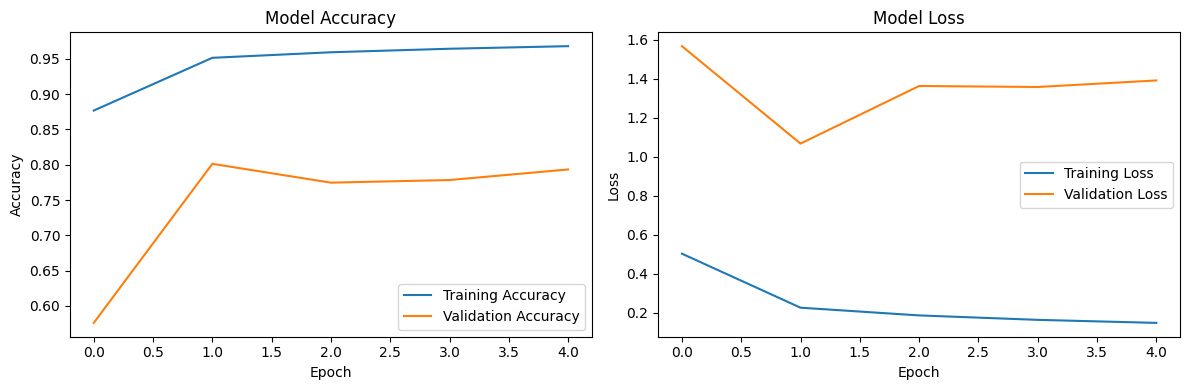

In [115]:
import matplotlib.pyplot as plt

# Graficar la precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Graficar la pérdida
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       1.00      1.00      1.00       476
                Acuerdo       0.89      1.00      0.94        64
            Acumulación       0.81      0.97      0.88        67
             Admisibles       1.00      1.00      1.00      1520
      Agréguese A Tabla       1.00      0.99      1.00      1264
               Apercibe       0.85      0.94      0.90       105
              Archivado       0.89      0.99      0.94        85
          Art / Numeral       0.83      1.00      0.91        29
      Concede Apelación       1.00      0.99      1.00       901
                     Cs       1.00      1.00      1.00       890
            Dese Cuenta       0.98      0.98      0.98       248
         Evacua Informe       1.00      0.98      0.99      1376
        Fallo/Desestima       1.00      0.98      0.99        59
            Fija Cost

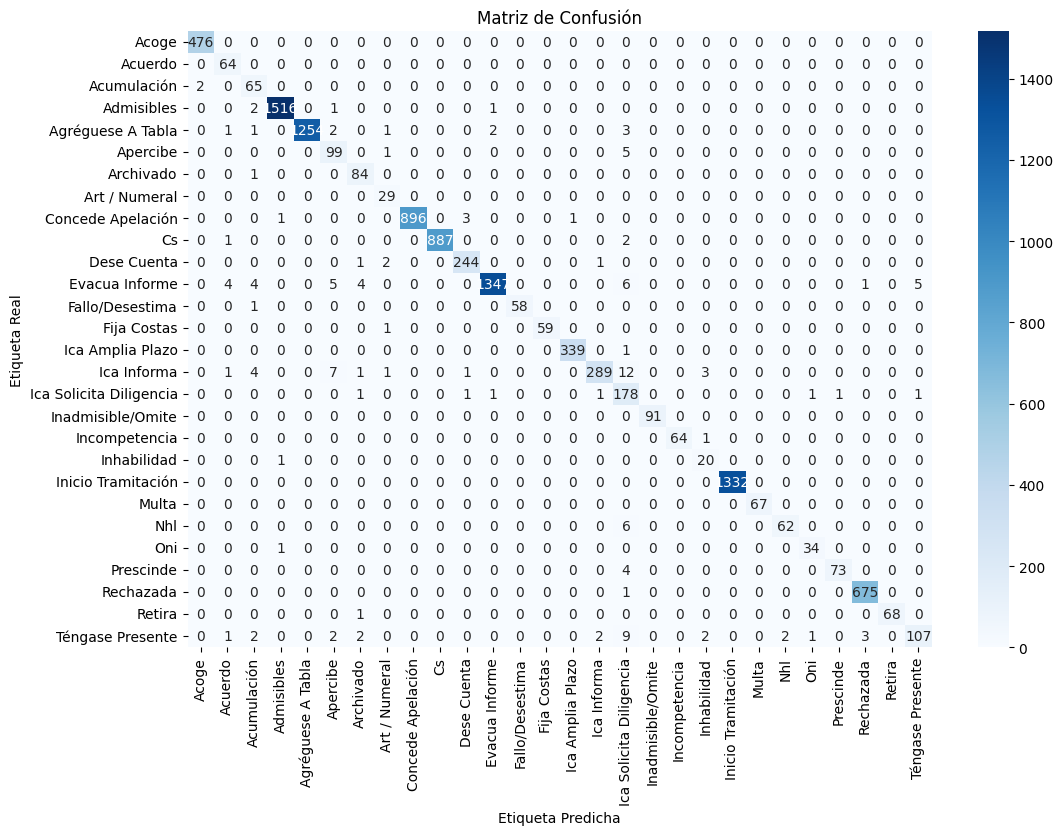

In [116]:
df_smote_2 = metricas_clases(X_test, model2)

### *QUITANDO EL SMOTE*

In [120]:
# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=total_words, output_dim=50, input_length=max_sequence_len))

# Capa LSTM
model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

# Capa densa
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)





In [121]:
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42)

In [122]:
history2 = model.fit(
    X_train, 
    y_train,
    epochs=5, 
    batch_size=32, 
    validation_data = (X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/5
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 54s 39ms/step - accuracy: 0.6205 - loss: 1.3060 - val_accuracy: 0.9650 - val_loss: 0.1705 - learning_rate: 0.0010
Epoch 2/5
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 51s 38ms/step - accuracy: 0.9598 - loss: 0.1808 - val_accuracy: 0.9888 - val_loss: 0.0952 - learning_rate: 0.0010
Epoch 3/5
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 52s 39ms/step - accuracy: 0.9820 - loss: 0.1040 - val_accuracy: 0.9902 - val_loss: 0.0798 - learning_rate: 0.0010
Epoch 4/5
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 51s 38ms/step - accuracy: 0.9844 - loss: 0.1032 - val_accuracy: 0.9919 - val_loss: 0.0728 - learning_rate: 0.0010
Epoch 5/5
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step - accuracy: 0.9921 - loss: 0.0669 - val_accuracy: 0.9931 - val_loss: 0.0700 - learning_rate: 0.0010


In [123]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


332/332 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9930 - loss: 0.0680
Test Loss: 0.06996908038854599, Test Accuracy: 0.9931274652481079


332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       1.00      1.00      1.00       476
                Acuerdo       0.97      1.00      0.98        64
            Acumulación       0.97      0.97      0.97        67
             Admisibles       1.00      1.00      1.00      1520
      Agréguese A Tabla       1.00      1.00      1.00      1264
               Apercibe       1.00      0.96      0.98       105
              Archivado       1.00      1.00      1.00        85
          Art / Numeral       0.96      0.93      0.95        29
      Concede Apelación       1.00      1.00      1.00       901
                     Cs       1.00      1.00      1.00       890
            Dese Cuenta       0.98      0.98      0.98       248
         Evacua Informe       0.99      0.99      0.99      1376
        Fallo/Desestima       1.00      1.00      1.00        59
            Fija Cost

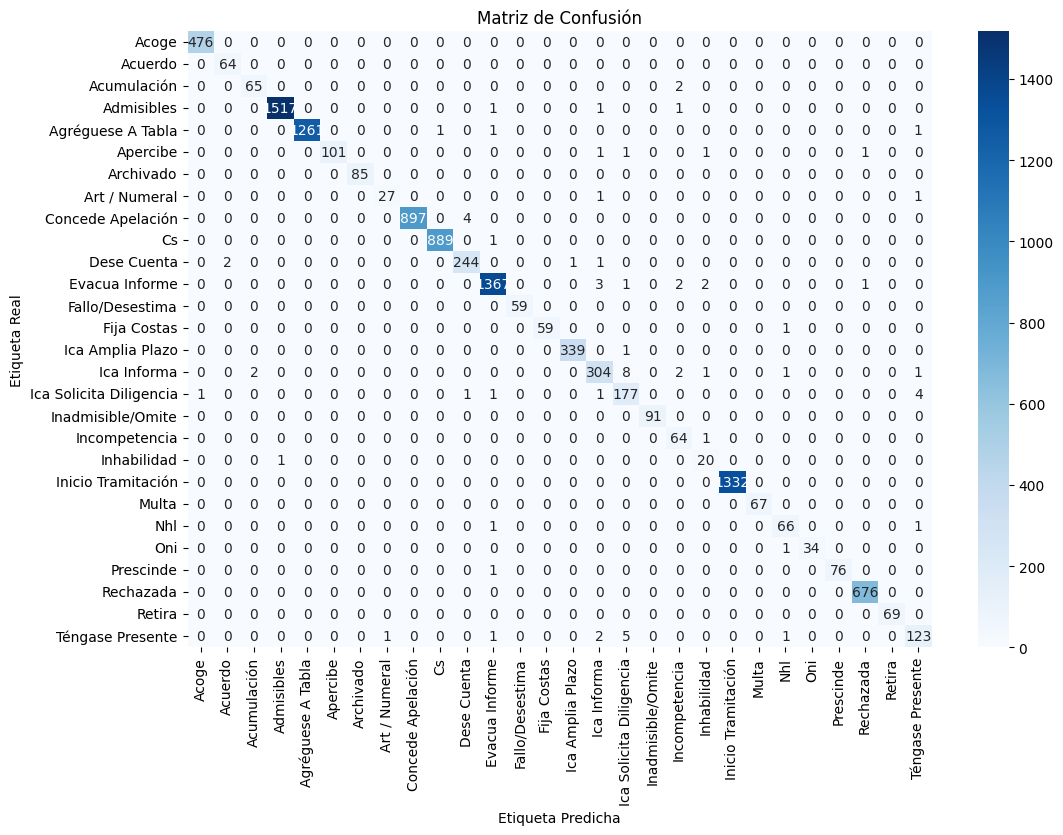

In [128]:
df_smote_3 = metricas_clases(X_test, model)

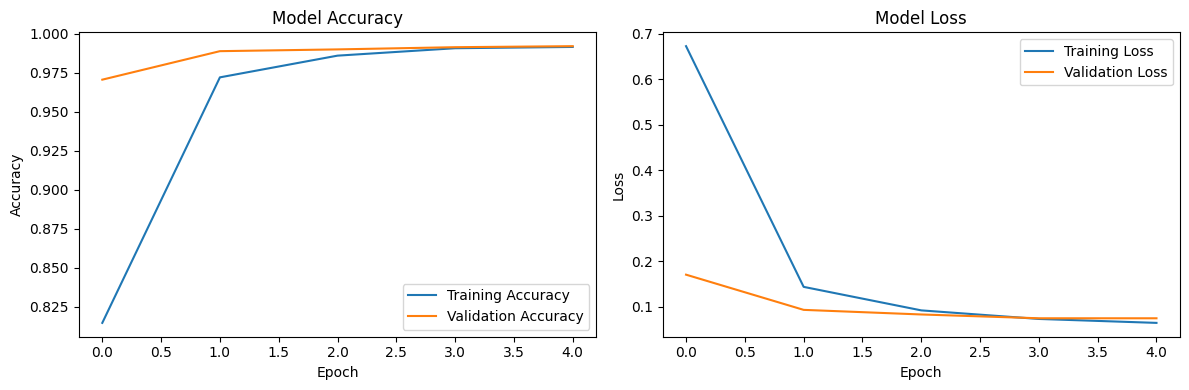

In [84]:
import matplotlib.pyplot as plt

# Graficar la precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Graficar la pérdida
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [76]:
y_train_int = y_train.argmax(axis=1)  # De one-hot a entero
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)
class_weights_dict = dict(enumerate(class_weights))

In [127]:
# Nuevo texto para probar
new_description = "Pone en conc.inhabilidad"

# Limpieza (usa la misma función que creaste anteriormente)
cleaned_description = cleaning_data(new_description)

# Tokenización del texto
tokenized_description = tokenizer.texts_to_sequences([cleaned_description])

# Padding para que tenga la misma longitud que las secuencias de entrenamiento
padded_description = pad_sequences(tokenized_description, maxlen=max_sequence_len, padding='pre')
# Realizar la predicción
prediction = model.predict(padded_description)

# Ordenar las probabilidades de mayor a menor y obtener los índices de las 3 clases más probables
top_3_indices = prediction[0].argsort()[-3:][::-1]

# Mapear índices a etiquetas originales
top_3_labels = label_encoder.inverse_transform(top_3_indices)

# Obtener las probabilidades correspondientes
top_3_probabilities = prediction[0][top_3_indices]
print("Top 3 predicciones más probables:")
for i in range(3):
    print(f"{i+1}. Clase: {top_3_labels[i]} - Probabilidad: {top_3_probabilities[i]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Top 3 predicciones más probables:
1. Clase: Ica Informa - Probabilidad: 0.52
2. Clase: Acumulación - Probabilidad: 0.27
3. Clase: Archivado - Probabilidad: 0.08


In [129]:
# Guardar modelo
model.save('modelo_fis_2.h5')


In [130]:
import pickle

# Guardar el tokenizer
with open('tokenizer_2.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [131]:
with open('label_encoder_2.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)